In [ ]:
import os
import pandas as pd
import json
import seaborn as sns
from typing import List

from experiments.interpretation.interpretation_util import (
    ExperimentFiles,
    ExperimentFolders,
)

file_to_compare = ExperimentFiles.ALL_TOOLS_MCP_SEQ

# Base directory setup
notebook_dir = os.path.abspath("")
base_experiment_dir = os.path.join(notebook_dir, "..", "results", "experiments")

dfs = []
all_llm_folders = list(ExperimentFolders)

for folder in all_llm_folders:
    path = os.path.join(base_experiment_dir, folder, file_to_compare)
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        dfs.append(df)
    except Exception as e:
        print(f"Failed to load {folder}/{file_to_compare}: {e}")

df = pd.concat(dfs, ignore_index=True)

# Now you can compare/filter by experiment_name
print(df["model_used"].value_counts())

model_used
gpt-4.1             91
o3                  91
gemini-2.0-flash    91
Name: count, dtype: int64


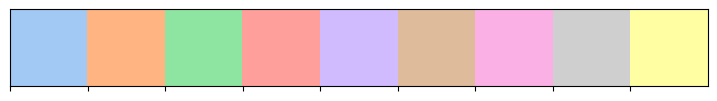

In [10]:
my_palette = sns.color_palette("pastel", 9)

sns.palplot(my_palette)

# Direct Fact Score

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_85434/2731538823.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_85434/2731538823.py:8: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  ax = sns.boxplot(


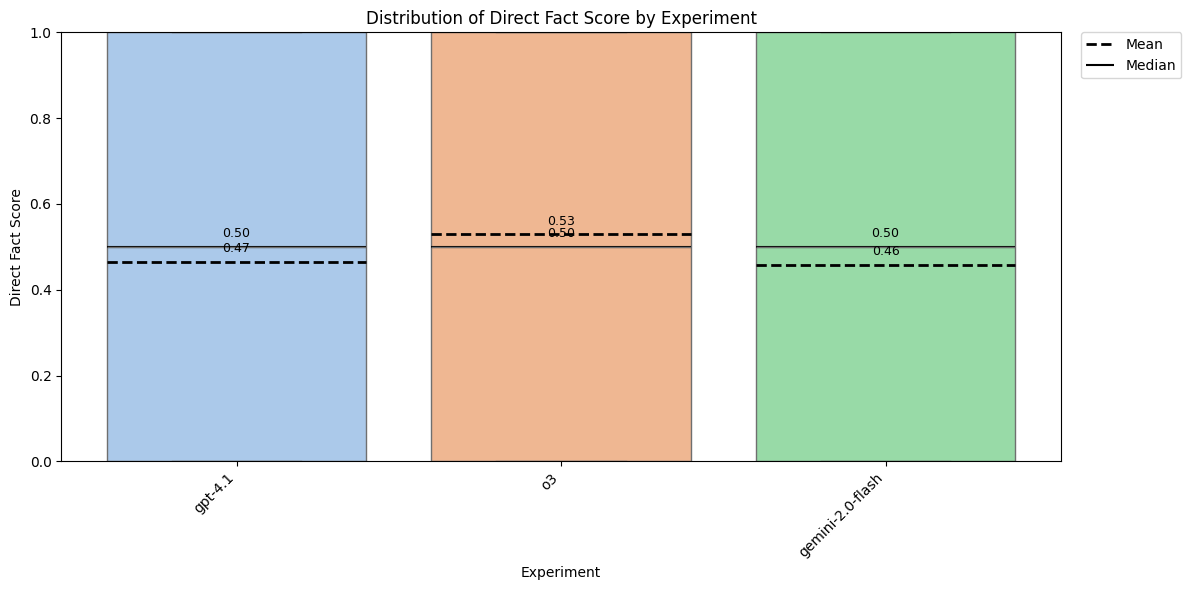

In [11]:
import matplotlib.pyplot as plt

import numpy as np

plt.figure(figsize=(12, 6))

# Draw boxplot and save the axis object
ax = sns.boxplot(
    data=df,
    x="model_used",
    y="fact_score.direct_fact_score",
    palette=my_palette,
    showfliers=False,
    linewidth=1,
)

# Get the x-tick positions (center of each box)
xticks = ax.get_xticks()
xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

# Compute statistics
means = df.groupby("model_used")["fact_score.direct_fact_score"].mean()
medians = df.groupby("model_used")["fact_score.direct_fact_score"].median()

# Map experiment names to positions
pos_map = {label: pos for label, pos in zip(xticklabels, xticks)}

# Overlay mean line and median label
for i, (experiment, pos) in enumerate(pos_map.items()):
    mean_val = means.get(experiment)
    median_val = medians.get(experiment)

    if mean_val is not None:
        # Mean (red dashed line)
        plt.hlines(
            mean_val,
            pos - 0.40,
            pos + 0.40,
            colors="black",
            linestyles="--",
            linewidth=2,
            label="Mean" if i == 0 else "",  # Label only once
        )
        plt.text(
            pos,
            mean_val + 0.015,
            f"{mean_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

    if median_val is not None:
        # Median label (black)
        plt.hlines(
            median_val,
            pos - 0.40,
            pos + 0.40,
            colors="black",
            linestyles="-",
            linewidth=1.5,
            label="Median" if i == 0 else "",  # Label only once
        )
        plt.text(
            pos,
            median_val + 0.015,
            f"{median_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

# Final formatting
plt.title("Distribution of Direct Fact Score by Experiment")
plt.xlabel("Experiment")
plt.ylabel("Direct Fact Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")

# Add legend outside top right
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
)

plt.tight_layout()
plt.show()

# Agent as a judge outcome

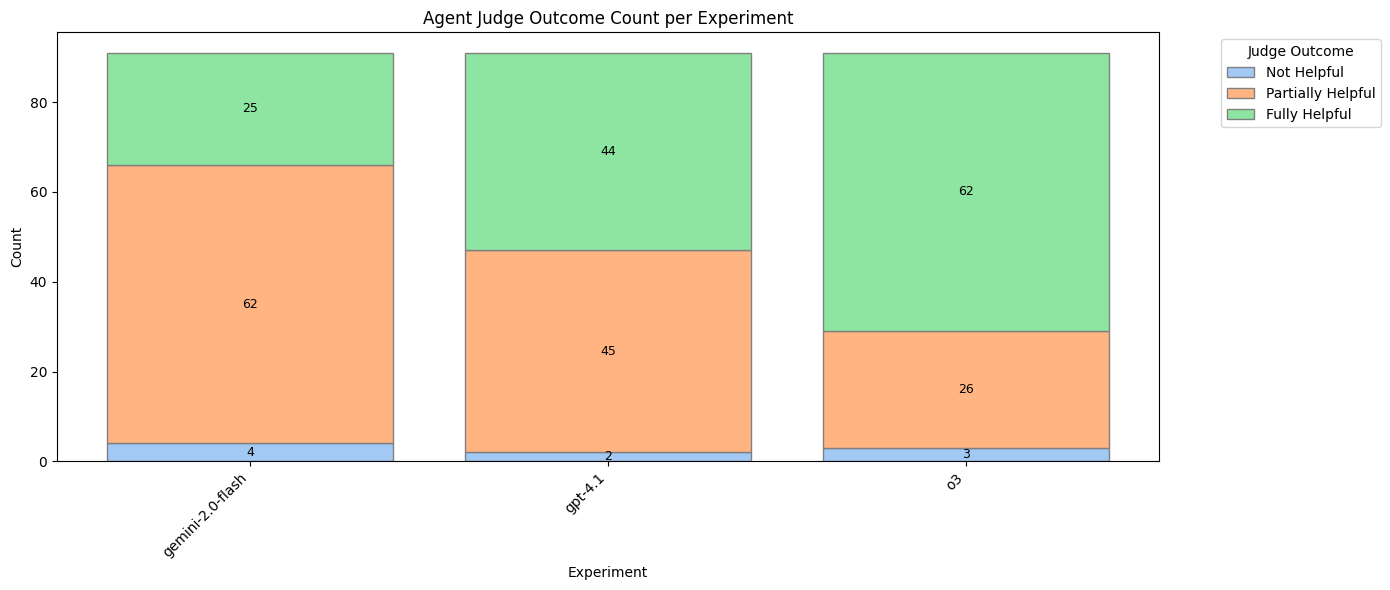

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
stacked_data = (
    df.groupby(["model_used", "agent_judge_outcome"]).size().unstack(fill_value=0)
)

# Desired outcome stacking order
desired_order = ["Not Helpful", "Partially Helpful", "Fully Helpful"]
stacked_data = stacked_data[desired_order]

# Plot
plt.figure(figsize=(14, 6))
bottom = [0] * len(stacked_data)

for idx, outcome in enumerate(desired_order):
    values = stacked_data[outcome].values
    bars = plt.bar(
        stacked_data.index,
        values,
        bottom=bottom,
        label=outcome,
        color=my_palette[idx],
        edgecolor="gray",
    )

    # Annotate each segment
    for i, (val, btm) in enumerate(zip(values, bottom)):
        if val > 0:
            plt.text(
                i,
                btm + val / 2,
                str(val),
                ha="center",
                va="center",
                fontsize=9,
                color="black",
            )

    # Update stacking bottom
    bottom = [btm + val for btm, val in zip(bottom, values)]

# Labels and legend
plt.title("Agent Judge Outcome Count per Experiment")
plt.xlabel("Experiment")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Judge Outcome", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Token Consumption

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_85434/2100959550.py:29: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.barplot(


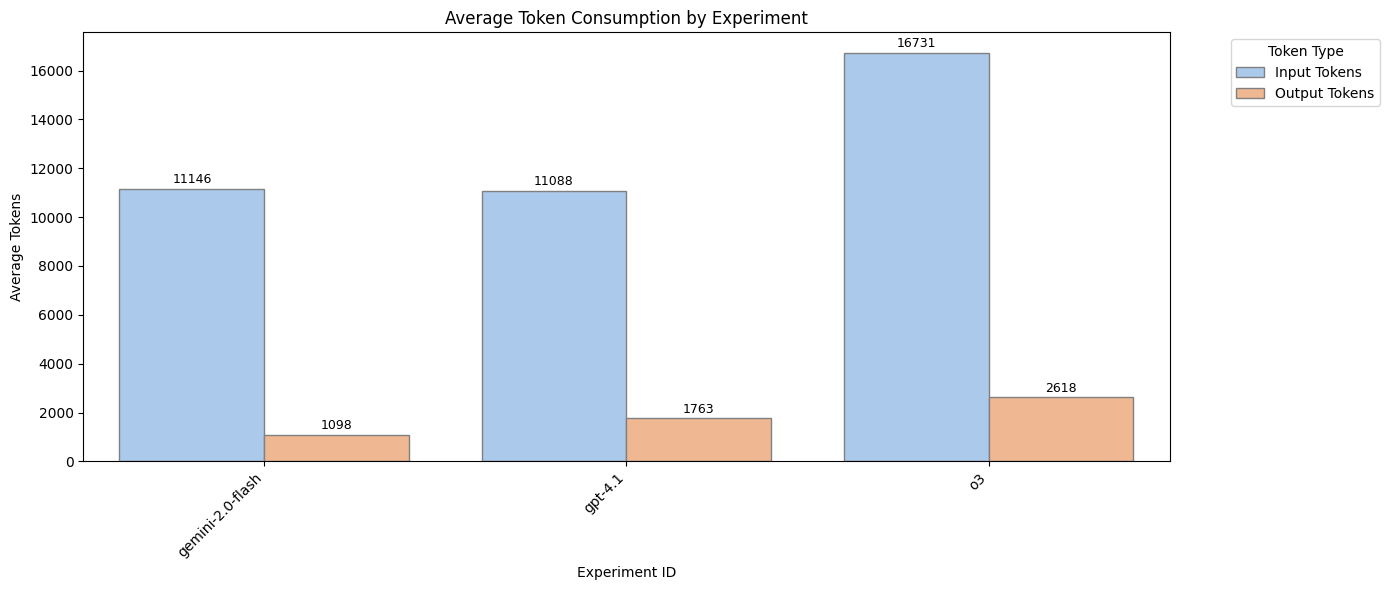

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mean token usage by experiment
token_cols = [
    "tokens_consumed.input_tokens",
    "tokens_consumed.output_tokens",
]

mean_token_usage = df.groupby("model_used")[token_cols].mean().reset_index()

# Melt for plotting
melted = mean_token_usage.melt(
    id_vars="model_used",
    value_vars=token_cols,
    var_name="token_type",
    value_name="avg_tokens",
)

# Label mapping and pastel palette
token_type_mapping = {
    "tokens_consumed.input_tokens": "Input Tokens",
    "tokens_consumed.output_tokens": "Output Tokens",
}
melted["token_type"] = melted["token_type"].map(token_type_mapping)

# Plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=melted,
    x="model_used",
    y="avg_tokens",
    hue="token_type",
    palette=my_palette,
    edgecolor="gray",
)

# Add numeric labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", label_type="edge", fontsize=9, padding=2)

# Formatting
plt.title("Average Token Consumption by Experiment")
plt.ylabel("Average Tokens")
plt.xlabel("Experiment ID")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Token Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

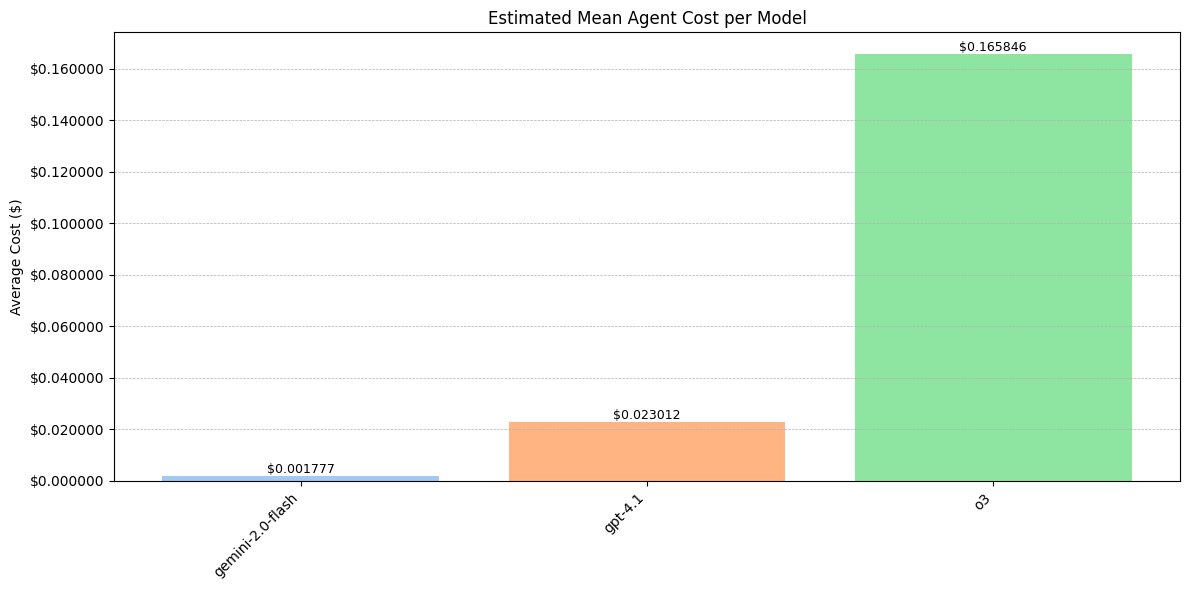

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from experiments.interpretation.interpretation_util import ModelPricing

# Group by model used
grouped = df.groupby("model_used")

agent_costs = {}

for model, group in grouped:
    avg_input = group["tokens_consumed.input_tokens"].mean()
    avg_output = group["tokens_consumed.output_tokens"].mean()

    cost = (avg_input / 1000) * ModelPricing[model]["input"] + (
        avg_output / 1000
    ) * ModelPricing[model]["output"]

    agent_costs[model] = cost

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(agent_costs.keys(), agent_costs.values(), color=my_palette)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.00005,
        f"${height:.6f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.ylabel("Average Cost ($)")
plt.title("Estimated Mean Agent Cost per Model")
plt.xticks(rotation=45, ha="right")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.6f}"))
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# BERTScore

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_85434/2071180431.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_85434/2071180431.py:9: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  ax = sns.barplot(


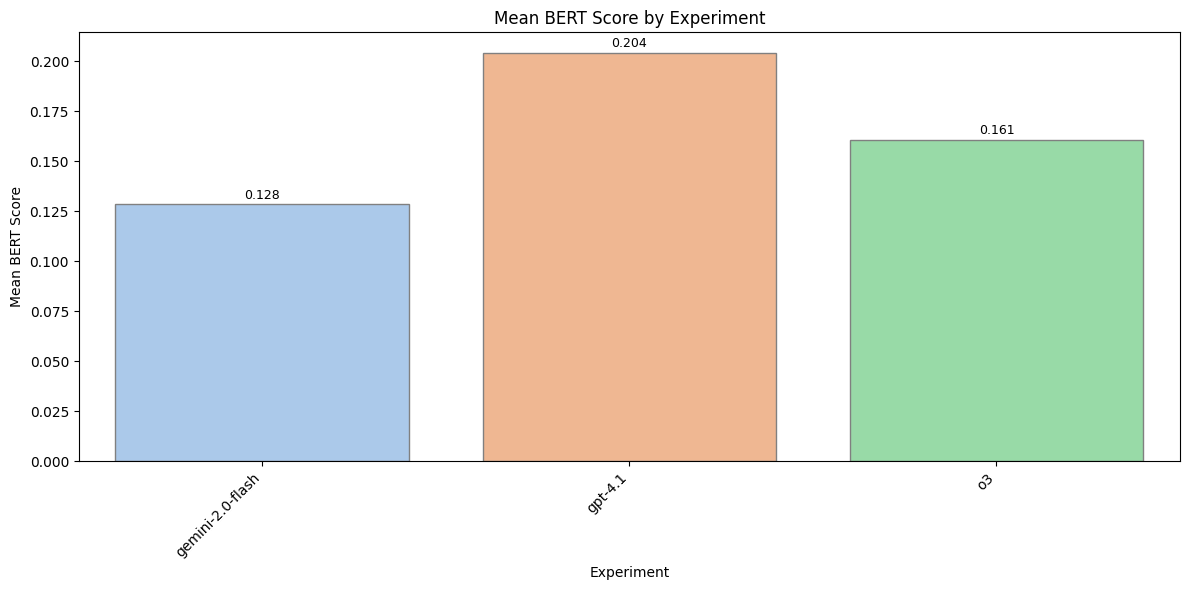

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute mean BERT score per experiment
mean_bert = df.groupby("model_used")["bert_score"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=mean_bert,
    x="model_used",
    y="bert_score",
    palette=my_palette,
    edgecolor="gray",
)

# Add numeric labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9, padding=2)

# Formatting
plt.title("Mean BERT Score by Experiment")
plt.xlabel("Experiment")
plt.ylabel("Mean BERT Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_85434/3869567000.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_85434/3869567000.py:9: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  ax = sns.barplot(


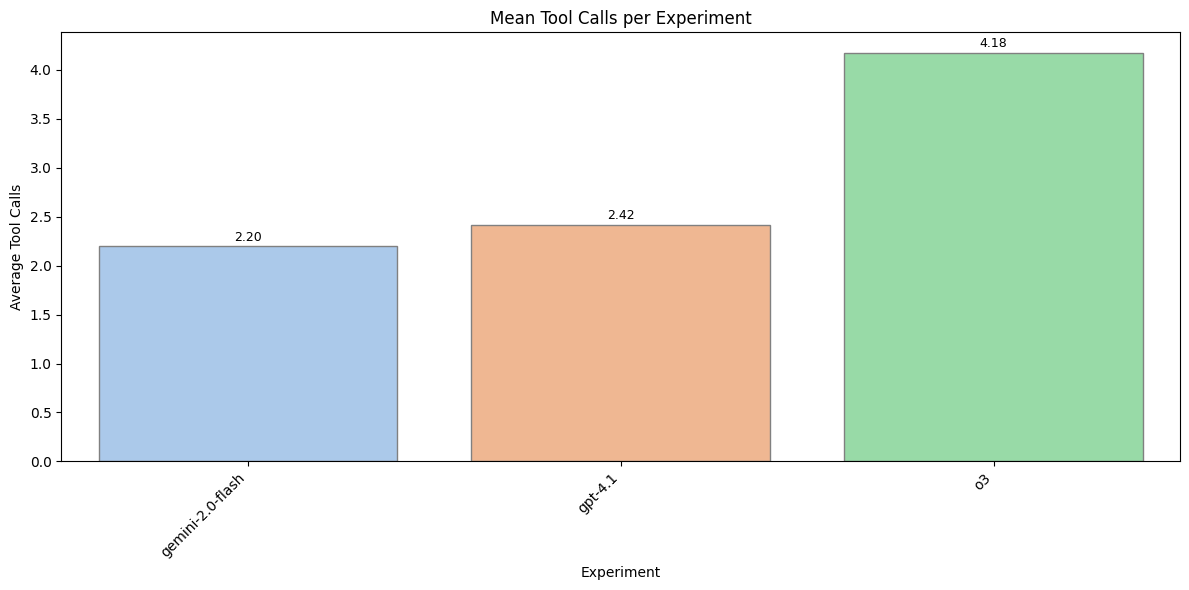

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute mean tool calls per experiment
mean_tools = df.groupby("model_used")["tool_calls_count"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=mean_tools,
    x="model_used",
    y="tool_calls_count",
    palette=my_palette,
    edgecolor="gray",
)

# Add numeric labels to bars, positioned just outside the top edge
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9, padding=2)

# Formatting
plt.title("Mean Tool Calls per Experiment")
plt.xlabel("Experiment")
plt.ylabel("Average Tool Calls")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()